In [1]:
import os
import pandas as pd
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timezone

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [3]:
def __smooth(y, npts, win="hanning"):

    from numpy import ones, convolve, hanning, nan

    if win == "hanning":
        win = hanning(npts)
    elif win == "boxcar":
        win = ones(npts)

    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [4]:
def __load_fsr_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_csv, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"romy_fsr_{str(dat)[:10].replace('-','')}.csv"
        try:
            df0 = read_csv(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    # df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(str(_t)) - UTCDateTime(df.datetime.iloc[0]) for _t in df.datetime]

    return df

In [5]:
config = {}

# path to data
# config['path'] = "./data/"
config['path'] = "/home/andbro/kilauea-data/romy_fsr/data/"
config['path'] = "/import/kilauea-data/romy_fsr/data/"

# specify time period
config['tbeg'] = "2024-08-21"
config['tend'] = "2024-08-26"

config['path_to_figs'] = "/import/kilauea-data/romy_fsr/figures/"


In [6]:
df0 = __load_fsr_data(config['tbeg'], config['tend'], config['path'])

2024-08-21
2024-08-22
2024-08-23
2024-08-24
2024-08-25
2024-08-26


In [7]:
# df0['datetime'] = [datetime.fromisoformat(_dt).astimezone(timezone.utc) for _dt in df0.datetime]

In [8]:
# free spectral range of ROMY
fsr = 8.94e6

# nth FSR peak
n = 12

# side length of cavity
L = 11.2

# perimeter of cavity
P = 3*L

In [9]:

# starttime = obs.UTCDateTime(df0.datetime.iloc[0])

# df0['time_sec'] = np.array([obs.UTCDateTime(_dt) - starttime for _dt in df0.datetime])

In [10]:
df = df0.copy()

df['time_utc'] = [obs.UTCDateTime(_t) for _t in df.datetime]

fmode = df.x_hz.iloc[0]*1e-6

dbm_threshold = 110

df['x_mod'] = np.where(abs(df.y_dbm) < dbm_threshold, df.x_hz, np.nan)

df['x_mod_rel'] = df.x_mod - np.nanmean(df.x_mod[:100])

df['x_mod_avg'] = df['x_mod'].rolling(60).median()

df['x_mod_avg_rel'] = df.x_mod_avg - np.nanmean(df.x_mod_avg[:100])

df['y_mod'] = np.where(abs(df.y_dbm) < dbm_threshold, df.y_dbm, np.nan)

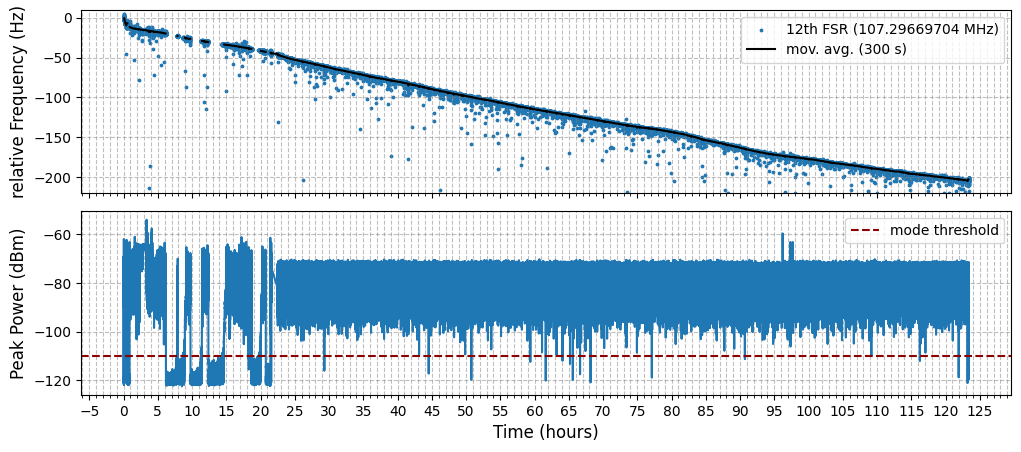

In [15]:
def __makeplot(df):

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 2, 1

    xscale = 1

    tscale, tunit = 1/3600, "hours"

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tsec = 300
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_rel, s=3, color="tab:blue", label=f"{n}th FSR ({fmode} MHz)")
    ax[0].plot(df['time_sec']*tscale, __smooth(df.x_mod_rel, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[0].ticklabel_format(useOffset=False)

    ax[0].set_ylim(-220, 10)

    ax[1].plot(df['time_sec']*tscale, df.y_dbm)
    ax[1].axhline(-dbm_threshold, color="darkred", ls="--", label="mode threshold")

    for i in range(Nrow):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend(loc=1, fontsize=font-2)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[0].set_ylabel("relative Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel("Peak Power (dBm)", fontsize=font)
    ax[1].set_xlabel(f"Time ({tunit})", fontsize=font)

    plt.show();
    return fig

fig = __makeplot(df);


In [12]:
# df['disp_um'] = 1e6 * P * df.x_mod_rel / (n * fsr)

df['disp'] = (3e8 / (df.x_mod_avg / n))

df['disp_rel'] = df.disp - np.nanmean(df.disp.iloc[:100])


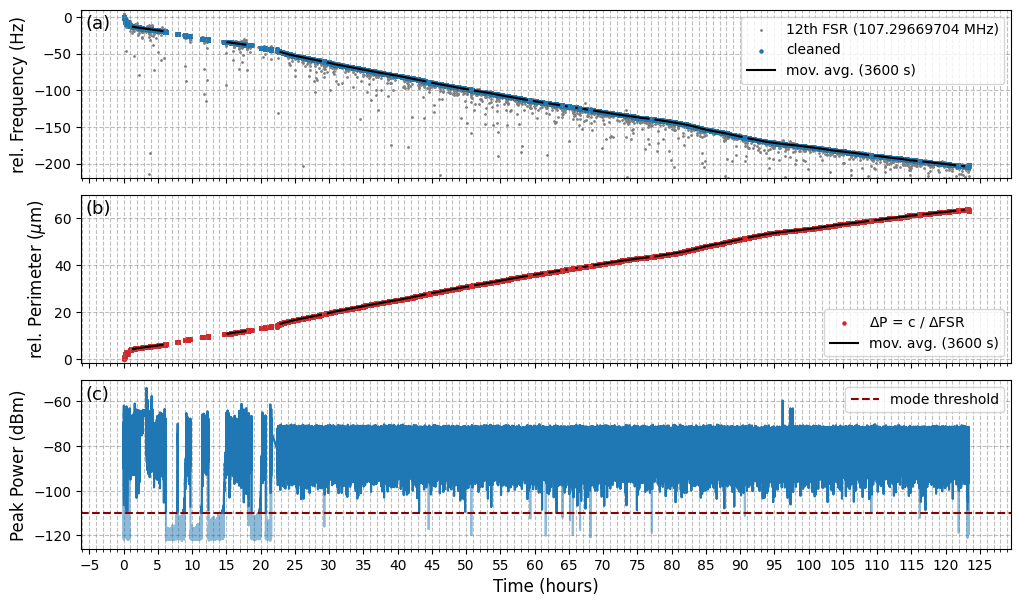

In [16]:
def __makeplot(df):

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 3, 1

    xscale = 1

    tscale, tunit = 1/3600, "hours"

    dscale, dunit = 1e6, "$\mu$m"

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 7), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tsec = 3600
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_rel, s=1, color="grey", label=f"{n}th FSR ({fmode} MHz)")
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_avg_rel, s=5, color="tab:blue", label=f"cleaned")
    ax[0].plot(df['time_sec']*tscale, __smooth(df.x_mod_avg_rel, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(-220, 10)

    ax[1].scatter(df['time_sec']*tscale, df.disp_rel*dscale, s=5, color="tab:red", label=f"$\Delta$P = c / $\Delta$FSR")
    ax[1].plot(df['time_sec']*tscale, __smooth(df.disp_rel*dscale, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylim(-2, 70)

    ax[2].plot(df['time_sec']*tscale, df.y_dbm, alpha=0.5)
    ax[2].plot(df['time_sec']*tscale, df.y_mod, color="tab:blue")
    ax[2].axhline(-dbm_threshold, color="darkred", ls="--", label="mode threshold")

    for i in range(Nrow):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend(loc=1, fontsize=font-2)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[1].legend(loc=4, fontsize=font-2)

    ax[0].set_ylabel(f"rel. Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel(f"rel. Perimeter ({dunit})", fontsize=font)
    ax[2].set_ylabel(f"Peak Power (dBm)", fontsize=font)
    ax[2].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _k, ll in enumerate(['(a)','(b)','(c)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    #     ax[_k].set_xlim(95, 105)
    # ax[0].set_ylim(-185, -170)
    # ax[1].set_ylim(53, 58)
    # ax[1].yaxis.set_minor_locator(MultipleLocator(0.633))
    # ax[1].yaxis.set_major_locator(MultipleLocator(3*0.633))

    plt.show();
    return fig

fig = __makeplot(df);

# fig.savefig(config['path_to_figs']+"RomyFSR_zoomin.png", format="png", dpi=150, bbox_inches='tight')


In [14]:
opath = data_path+"manuscripts/manuscript_romy_drifts/data/"

df.to_pickle(opath+"romy_fsr.pkl")